# Train a text classifier using Amazon SageMaker BlazingText built-in algorithm

### Introduction

In this lab you will use SageMaker BlazingText built-in algorithm to predict the sentiment for each customer review. BlazingText is a variant of FastText which is based on word2vec. For more information on BlazingText, see the documentation here:  https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html

### Table of Contents

- [1. Prepare dataset](#c1w4-1.)
  - [1.1. Load the dataset](#c1w4-1.1.)
  - [1.2. Transform the dataset](#c1w4-1.2.)
    - [Exercise 1](#c1w4-ex-1)
  - [1.3. Split the dataset into train and validation sets](#c1w4-1.3.)
  - [1.4. Upload the `train` and `validation` datasets to S3 bucket](#c1w4-1.4.)
- [2. Train the model](#c1w4-2.)
  - [Exercise 2](#c1w4-ex-2)
  - [Exercise 3](#c1w4-ex-3)
  - [Exercise 4](#c1w4-ex-4)
  - [Exercise 5](#c1w4-ex-5)
  - [Exercise 6](#c1w4-ex-6)
  - [Exercise 7](#c1w4-ex-7)
- [3. Deploy the model](#c1w4-3.)
- [4. Test the model](#c1w4-4.)

Let's install and import required modules.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q nltk==3.5
!pip install -q protobuf==3.20.*

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w4')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

<a name='c1w4-1.'></a>
# 1. Prepare dataset
Let's adapt the dataset into a format that BlazingText understands. The BlazingText format is as follows:

```
__label__<label> "<features>"
```

Here are some examples:
```
__label__-1 "this is bad"
__label__0 "this is ok"
__label__1 "this is great"
```

Sentiment is one of three classes: negative (-1), neutral (0), or positive (1).  BlazingText requires that `__label__` is prepended to each sentiment value.

You will tokenize the `review_body` with the Natural Language Toolkit (`nltk`) for the model training. `nltk` documentation can be found [here](https://www.nltk.org/). You will also use `nltk` later in this lab to tokenize reviews to use as inputs to the deployed model.

<a name='c1w4-1.1.'></a>
### 1.1. Load the dataset

Upload the dataset into the Pandas dataframe:

In [5]:
!aws s3 cp 's3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv' ./

download: s3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv to ./womens_clothing_ecommerce_reviews_balanced.csv


In [6]:
path = './womens_clothing_ecommerce_reviews_balanced.csv'

df = pd.read_csv(path, delimiter=',')
df.head()

,sentiment,review_body,product_category
0,-1,This suit did nothing for me. the top has zero...,Swim
1,-1,Like other reviewers i saw this dress on the ...,Dresses
2,-1,I wish i had read the reviews before purchasin...,Knits
3,-1,I ordered these pants in my usual size (xl) an...,Legwear
4,-1,I noticed this top on one of the sales associa...,Knits


<a name='c1w4-1.2.'></a>
### 1.2. Transform the dataset
Now you will prepend `__label__` to each sentiment value and tokenize the review body using `nltk` module. Let's import the module and download the tokenizer:

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

To split a sentence into tokens you can use `word_tokenize` method. It will separate words, punctuation, and apply some stemming. Have a look at the example:

In [8]:
sentence = "I'm not a fan of this product!"

tokens = nltk.word_tokenize(sentence)
print(tokens)

['I', "'m", 'not', 'a', 'fan', 'of', 'this', 'product', '!']


The output of word tokenization can be converted into a string separated by spaces and saved in the dataframe. The transformed sentences are prepared then for better text understending by the model. 

Let's define a `prepare_data` function which you will apply later to transform both training and validation datasets. 

<a name='c1w4-ex-1'></a>
### Exercise 1

Apply the tokenizer to each of the reviews in the `review_body` column of the dataframe `df`.

In [9]:
def tokenize(review):
    # delete commas and quotation marks, apply tokenization and join back into a string separating by spaces
    return ' '.join([str(token) for token in nltk.word_tokenize(str(review).replace(',', '').replace('"', '').lower())])
    
def prepare_data(df):
    df['sentiment'] = df['sentiment'].map(lambda sentiment : '__label__{}'.format(str(sentiment).replace('__label__', '')))
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    df['review_body'] = df['review_body'].map(lambda review : tokenize(review)) # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    return df

Test the prepared function and examine the result.

In [10]:
# create a sample dataframe
df_example = pd.DataFrame({
    'sentiment':[-1, 0, 1], 
    'review_body':[
        "I don't like this product!", 
        "this product is ok", 
        "I do like this product!"]
})

# test the prepare_data function
print(prepare_data(df_example))

# Expected output:
#      sentiment                   review_body
# 0  __label__-1  i do n't like this product !
# 1   __label__0            this product is ok
# 2   __label__1      i do like this product !

     sentiment                   review_body
0  __label__-1  i do n't like this product !
1   __label__0            this product is ok
2   __label__1      i do like this product !


Apply the `prepare_data` function to the dataset. 

In [11]:
df_blazingtext = df[['sentiment', 'review_body']].reset_index(drop=True)
df_blazingtext = prepare_data(df_blazingtext)
df_blazingtext.head()

,sentiment,review_body
0,__label__-1,this suit did nothing for me . the top has zer...
1,__label__-1,like other reviewers i saw this dress on the c...
2,__label__-1,i wish i had read the reviews before purchasin...
3,__label__-1,i ordered these pants in my usual size ( xl ) ...
4,__label__-1,i noticed this top on one of the sales associa...


<a name='c1w4-1.3.'></a>
### 1.3. Split the dataset into train and validation sets
Split and visualize a pie chart of the train (90%) and validation (10%) sets. You can do the split using the `sklearn` model function.

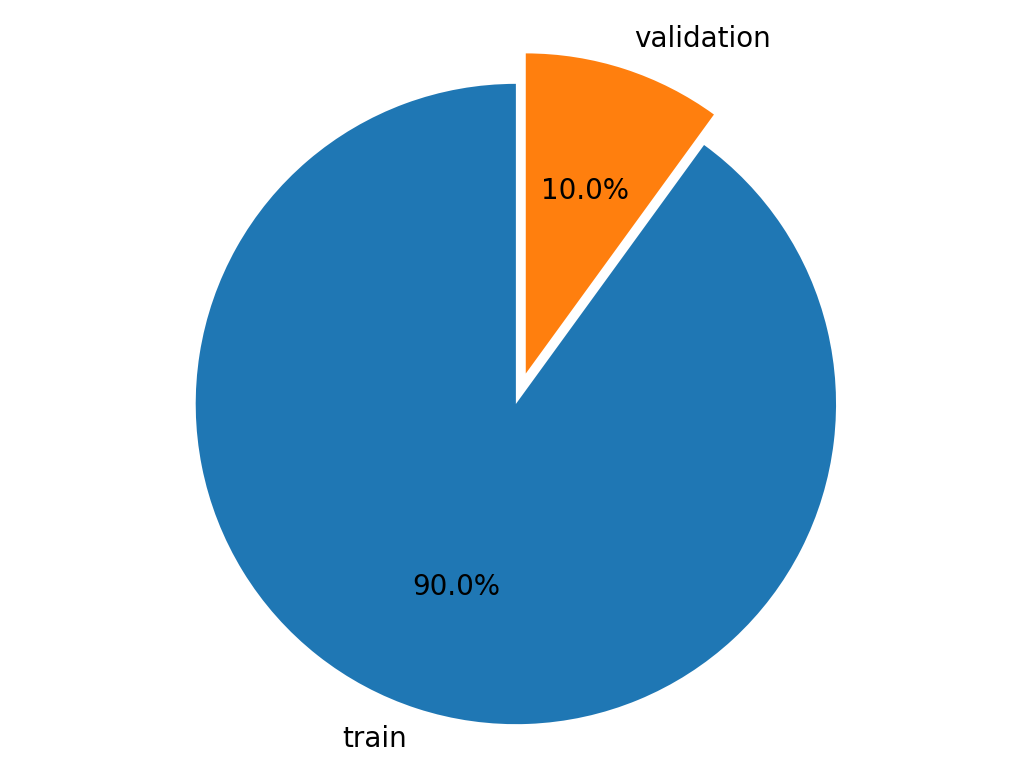

6399


In [12]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_validation = train_test_split(df_blazingtext, 
                                           test_size=0.10,
                                           stratify=df_blazingtext['sentiment'])

labels = ['train', 'validation']
sizes = [len(df_train.index), len(df_validation.index)]
explode = (0.1, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()
print(len(df_train))

Save the results as CSV files.

In [13]:
blazingtext_train_path = './train.csv'
df_train[['sentiment', 'review_body']].to_csv(blazingtext_train_path, index=False, header=False, sep=' ')

In [14]:
blazingtext_validation_path = './validation.csv'
df_validation[['sentiment', 'review_body']].to_csv(blazingtext_validation_path, index=False, header=False, sep=' ')

<a name='c1w4-1.4.'></a>
### 1.4. Upload the `train` and `validation` datasets to S3 bucket
You will use these to train and validate your model. Let's save them to S3 bucket.

In [15]:
train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_train_path)
validation_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_validation_path)

<a name='c1w4-2.'></a>
# 2. Train the model

Setup the BlazingText estimator. For more information on Estimators, see the SageMaker Python SDK documentation here: https://sagemaker.readthedocs.io/.

<a name='c1w4-ex-2'></a>
### Exercise 2

Setup the container image to use for training with the BlazingText algorithm.

**Instructions**: Use the `sagemaker.image_uris.retrieve` function with the `blazingtext` algorithm. 

```python
image_uri = sagemaker.image_uris.retrieve(
    region=region,
    framework='...' # the name of framework or algorithm
)
```

In [16]:
image_uri = sagemaker.image_uris.retrieve(
    region=region,
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    framework='blazingtext' # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

<a name='c1w4-ex-3'></a>
### Exercise 3

Create an estimator instance passing the container image and other instance parameters.

**Instructions**: Pass the container image prepared above into the `sagemaker.estimator.Estimator` function.

**Note**: For the purposes of this lab, you will use a relatively small instance type. Please refer to [this](https://aws.amazon.com/sagemaker/pricing/) link for additional instance types that may work for your use case outside of this lab.

In [17]:
estimator = sagemaker.estimator.Estimator(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    image_uri=image_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.large',
    volume_size=30,
    max_run=7200,
    sagemaker_session=sess
)

Configure the hyper-parameters for BlazingText. You are using BlazingText for a supervised classification task. For more information on the hyper-parameters, see the documentation here:  https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html

The hyperparameters that have the greatest impact on word2vec objective metrics are: `learning_rate` and `vector_dim`.

In [18]:
estimator.set_hyperparameters(mode='supervised',   # supervised (text classification)
                              epochs=10,           # number of complete passes through the dataset: 5 - 15
                              learning_rate=0.01,  # step size for the  numerical optimizer: 0.005 - 0.01
                              min_count=2,         # discard words that appear less than this number: 0 - 100                              
                              vector_dim=300,      # number of dimensions in vector space: 32-300
                              word_ngrams=3)       # number of words in a word n-gram: 1 - 3

To call the `fit` method for the created estimator instance you need to setup the input data channels. This can be organized as a dictionary

```python
data_channels = {
    'train': ..., # training data
    'validation': ... # validation data
}
```

where training and validation data are the Amazon SageMaker channels for S3 input data sources.

<a name='c1w4-ex-4'></a>
### Exercise 4

Create a train data channel.

**Instructions**: Pass the S3 input path for training data into the `sagemaker.inputs.TrainingInput` function.

In [19]:
train_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    train_s3_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

<a name='c1w4-ex-5'></a>
### Exercise 5

Create a validation data channel.

**Instructions**: Pass the S3 input path for validation data into the `sagemaker.inputs.TrainingInput` function.

In [20]:
validation_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    validation_s3_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

<a name='c1w4-ex-6'></a>
### Exercise 6

Organize the data channels defined above as a dictionary.

In [21]:
data_channels = {
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    'train': train_data, # Replace None
    'validation': validation_data # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
}

<a name='c1w4-ex-7'></a>
### Exercise 7

Start fitting the model to the dataset.

**Instructions**: Call the `fit` method of the estimator passing the configured train and validation inputs (data channels).

```python
estimator.fit(
    inputs=..., # train and validation input
    wait=False # do not wait for the job to complete before continuing
)
```

In [22]:
estimator.fit(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    inputs=data_channels, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    wait=False
)

training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

Training Job Name:  blazingtext-2023-12-30-07-17-14-540


Review the training job in the console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Training jobs`
- check the name of the training job, its status and other available information

In [23]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training job</a></b>'.format(region, training_job_name)))

/tmp/ipykernel_55/3585361345.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Review the Cloud Watch logs (after about 5 minutes).

**Instructions**: 
- open the link
- open the log stream with the name, which starts from the training job name
- have a quick look at the log messages

In [24]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> (after about 5 minutes)</b>'.format(region, training_job_name)))

/tmp/ipykernel_55/1685692383.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Wait for the training job to complete.

### _This cell will take approximately 5-10 minutes to run._

In [25]:
%%time

estimator.latest_training_job.wait(logs=False)


2023-12-30 07:17:14 Starting - Starting the training job..
2023-12-30 07:17:29 Starting - Preparing the instances for training............
2023-12-30 07:18:35 Downloading - Downloading input data........
2023-12-30 07:19:20 Downloading - Downloading the training image..
2023-12-30 07:19:35 Training - Training image download completed. Training in progress.......
2023-12-30 07:20:11 Uploading - Uploading generated training model...................
2023-12-30 07:21:51 Completed - Training job completed
CPU times: user 185 ms, sys: 30.3 ms, total: 216 ms
Wall time: 4min 39s


Review the train and validation accuracy.

_Ignore any warnings._

In [26]:
estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.5234
1,0.0,validation:accuracy,0.5049


Review the trained model in the S3 bucket.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon S3` -> `[bucket name]` -> `[training job name]` (Example: `Amazon S3` -> `sagemaker-us-east-1-82XXXXXXXXXXX` -> `blazingtext-20XX-XX-XX-XX-XX-XX-XXX`)
- check the existence of the `model.tar.gz` file in the `output` folder

In [27]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/output/?region={}&tab=overview">Trained model</a> in S3</b>'.format(bucket, training_job_name, region)))


/tmp/ipykernel_55/3152289013.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<a name='c1w4-3.'></a>
# 3. Deploy the model

Now deploy the trained model as an Endpoint.

### _This cell will take approximately 5-10 minutes to run._

In [28]:
%%time

text_classifier = estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m5.large',
                                   serializer=sagemaker.serializers.JSONSerializer(),
                                   deserializer=sagemaker.deserializers.JSONDeserializer())

print()
print('Endpoint name:  {}'.format(text_classifier.endpoint_name))

------!
Endpoint name:  blazingtext-2023-12-30-07-21-54-488
CPU times: user 54.6 ms, sys: 2.5 ms, total: 57.1 ms
Wall time: 3min 2s


Review the endpoint in the AWS console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Endpoints` -> `[Endpoint name]` (Example: `Amazon SageMaker` -> `Endpoints` -> `blazingtext-20XX-XX-XX-XX-XX-XX-XXX`)
- check the status and other available information about the Endpoint

In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, text_classifier.endpoint_name)))


/tmp/ipykernel_55/3114295367.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<a name='c1w4-4.'></a>
# 4. Test the model

Import the `nltk` library to convert the raw reviews into tokens that BlazingText recognizes.

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Specify sample reviews to predict the sentiment.

In [31]:
reviews = ['This product is great!',
           'OK, but not great',
           'This is not the right product.'] 

Tokenize the reviews and specify the payload to use when calling the REST API. 

In [32]:
tokenized_reviews = [' '.join(nltk.word_tokenize(review)) for review in reviews]

payload = {"instances" : tokenized_reviews}
print(payload)

{'instances': ['This product is great !', 'OK , but not great', 'This is not the right product .']}


Now you can predict the sentiment for each review. Call the `predict` method of the text classifier passing the tokenized sentence instances (`payload`) into the data argument.

In [33]:
predictions = text_classifier.predict(data=payload)
for prediction in predictions:
    print('Predicted class: {}'.format(prediction['label'][0].lstrip('__label__')))

Predicted class: 1
Predicted class: 0
Predicted class: -1


Upload the notebook into S3 bucket for grading purposes.

**Note**: you may need to click on "Save" button before the upload.

In [34]:
!aws s3 cp ./C1_W4_Assignment.ipynb s3://$bucket/C1_W4_Assignment_Learner.ipynb

upload: ./C1_W4_Assignment.ipynb to s3://sagemaker-us-east-1-404722161993/C1_W4_Assignment_Learner.ipynb


Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).